# Customer Segmentation

### Data Wrangling

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 100})
sns.set_style("whitegrid")
sns.set()

### Read csv and load data

In [2]:
df = pd.read_csv("online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


### Get some information about data 
### i.e column names , thier data types , number of records

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Get shape of dataframe

In [4]:
features = ["Invoice", "StockCode", "Description", "Quantity",
            "InvoiceDate", "Price", "Customer ID", "Country"]

rows, cols = df.shape
print("Rows :", rows)
print("Columns :", cols)

Rows : 541910
Columns : 8


# 1. Data Preprocessing

### Lets find and handle missing values

In [5]:
# Get missing values
def get_missing_data(data):
    # Get total number of missing values in each variable
    total = data.isnull().sum().sort_values(ascending=False)

    # Get percentage of missing values
    percent = ((data.isnull().sum()/data.isnull().count())
               * 100).sort_values(ascending=False)

    # Create dataframe for missing data
    missing_data = pd.concat([total, percent], axis=1,
                             keys=["Total", "Percent (%)"])
    return missing_data.style.background_gradient(cmap="Blues")


missing_data = get_missing_data(df)
missing_data

,Total,Percent (%)
Customer ID,135080,24.926648
Description,1454,0.268310
Invoice,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Country,0,0.000000


### Since we have 25% of missing values in Customer ID feature,Lets remove those records, since Customer ID is important feature we cant delete entire column

In [6]:
df.dropna(axis=0, inplace=True)
missing_data = get_missing_data(df)
missing_data

,Total,Percent (%)
Invoice,0,0.000000
StockCode,0,0.000000
Description,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Customer ID,0,0.000000
Country,0,0.000000


### Lets find and remove the duplicates

In [7]:
df.duplicated().sum()

5225

### As we can see we have total 5268 duplicate records, its better to remove them

In [8]:
df.drop_duplicates(subset=features, keep=False, inplace=True)
df.duplicated().sum()

# Lets get dimensions of filtered data
df.shape

(396768, 8)

In [9]:
df.describe()

,Quantity,Price,Customer ID
count,396768.000000,396768.000000,396768.000000
mean,12.298885,3.487089,15275.101976
std,251.780854,70.187364,1714.404737
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13919.000000
50%,5.000000,1.950000,15132.000000
75%,12.000000,3.750000,16779.000000
max,80995.000000,38970.000000,18287.000000


## Observations:
### From above stats, minimum amount of quantity ordered is negative which is not possible. So lets make our dataset clean by handling these negative values

In [10]:
df = df[df["Quantity"] > 0]
df.describe()

,Quantity,Price,Customer ID
count,387924.000000,387924.000000,387924.000000
mean,13.278585,3.134669,15281.614290
std,182.689972,22.376584,1713.957221
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13941.000000
50%,6.000000,1.950000,15144.000000
75%,12.000000,3.750000,16788.000000
max,80995.000000,8142.750000,18287.000000


In [11]:
df.shape

(387924, 8)

### Handle canceled transactions

In [12]:
invoices = df['Invoice']
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)
x = x.astype(int)
df['Order_Canceled'] = x
df['Order_Canceled'].value_counts()
df.reset_index(drop=True, inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Order_Canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0


# 2. EDA - Exploratory Data Analysis

### Now lets perform the EDA

## 1. How many different transactions, unique customers and different countries are there?

In [13]:
transactions = len(df["Invoice"].value_counts())
customers = len(df["Customer ID"].value_counts())
countries = len(df["Country"].value_counts())
products = len(df["StockCode"].value_counts())

unique_elements = pd.DataFrame([["Products", products], ["Transactions", transactions], [
                               "Customers", customers], ["Countries", countries]], columns=["Element", "Count"])
unique_elements.style.background_gradient(cmap="Blues")

# Or using nunique method of pandas
# unique_elements=df[["Customer ID","Invoice","StockCode","Country"]].nunique()

,Element,Count
0,Products,3665
1,Transactions,18535
2,Customers,4339
3,Countries,37


## Observations:
### There are unique:
#### 3684 Products
#### 22185 Transactions
#### 4372 Customers
#### 37 Countries
### It seems that each product have multiple transactions

### Lets get transactions as per country

In [14]:
countrywise_transactions = df.groupby(["Country"])
country = list(countrywise_transactions.groups.keys())
count = countrywise_transactions["Country"].count()
count

Country
Australia                 1183
Austria                    398
Bahrain                     17
Belgium                   2031
Brazil                      32
Canada                     151
Channel Islands            746
Cyprus                     593
Czech Republic              25
Denmark                    380
EIRE                      7218
European Community          60
Finland                    685
France                    8313
Germany                   9012
Greece                     145
Iceland                    182
Israel                     242
Italy                      758
Japan                      321
Lebanon                     45
Lithuania                   35
Malta                      112
Netherlands               2363
Norway                    1072
Poland                     330
Portugal                  1445
RSA                         58
Saudi Arabia                 9
Singapore                  222
Spain                     2475
Sweden                     449


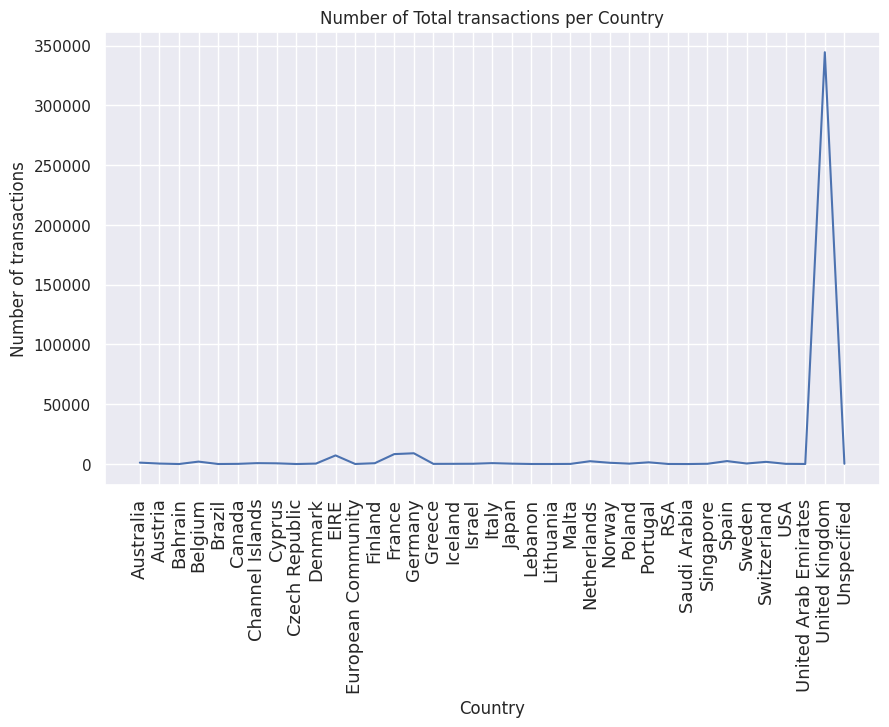

In [15]:
# plot line graph
plt.figure(figsize=(10, 6))
plt.plot(country, count,)
plt.gca().set(title="Number of Total transactions per Country",
              xlabel="Country", ylabel="Number of transactions")
plt.xticks(rotation=90, fontsize=13)
plt.show()

### Lets find number of unique transactions

In [16]:
country = countrywise_transactions.groups.keys()
count = countrywise_transactions["Invoice"].nunique()
percents = (countrywise_transactions["Invoice"].nunique(
)/len(countrywise_transactions["Invoice"].value_counts())*100)

unique_countrywise_transactions = pd.concat([count, percents], axis=1,
                                            keys=["Count", "Percent (%)"]).sort_values(by="Percent (%)", ascending=False).style.background_gradient(cmap="Blues")
unique_countrywise_transactions

,Count,Percent (%)
Country,,
United Kingdom,16648,89.819261
Germany,457,2.465606
France,389,2.098732
EIRE,260,1.402752
Belgium,98,0.528729
Netherlands,95,0.512544
Spain,90,0.485568
Australia,57,0.307526
Portugal,57,0.307526


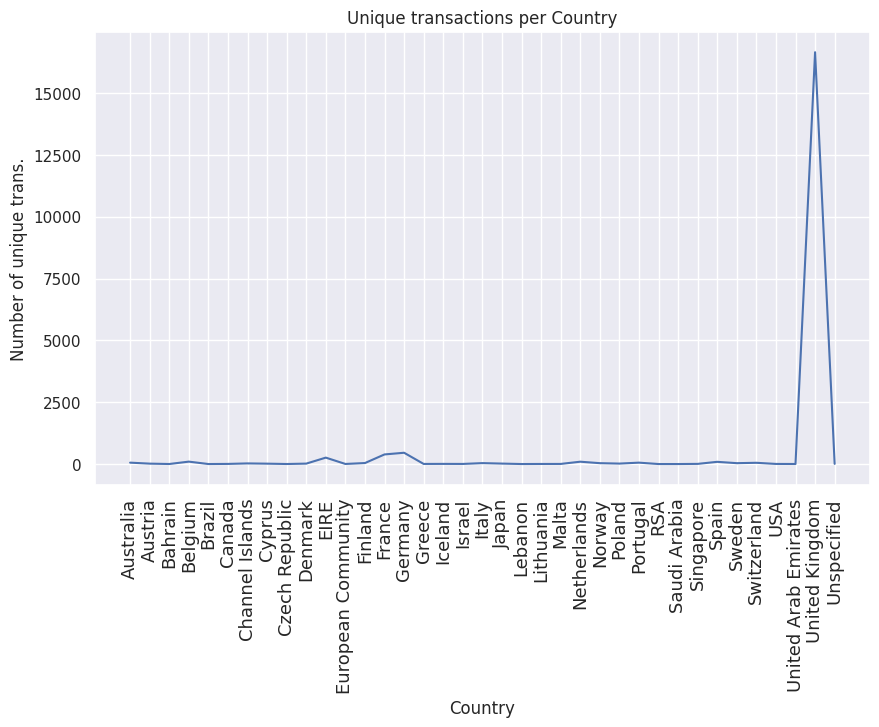

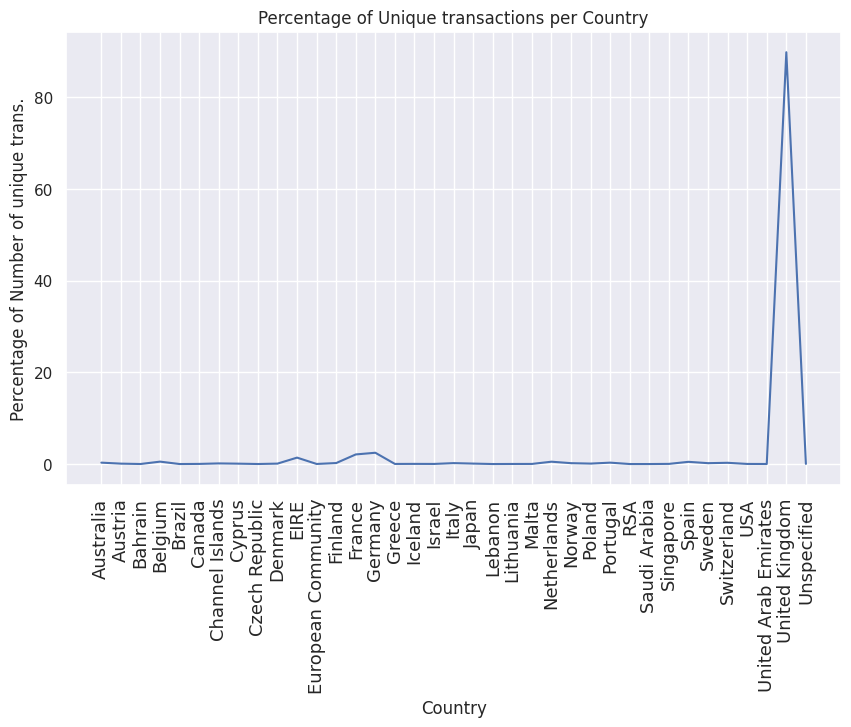

In [17]:
# plot line graph
plt.figure(figsize=(10, 6))
plt.plot(country, count)
plt.gca().set(title="Unique transactions per Country",
              xlabel="Country", ylabel="Number of unique trans.")
plt.xticks(rotation=90, fontsize=13)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(country, percents)
plt.gca().set(title="Percentage of Unique transactions per Country",
              xlabel="Country", ylabel="Percentage of Number of unique trans.")
plt.xticks(rotation=90, fontsize=13)
plt.show()

## Observations:
### United Kingdom 89 % of unique transactions ( 19852 )
### Brazil, Baharin , Lebonan, RSA, Saudi Arabia have made the least number of transactions (1,2, etc)

### UK makes almost 90% of orders , no other country makes near to 3%

## As UK makes 89% of orders ,lets take orders from UK and create new dataframe

In [18]:
df_UK = df[df["Country"] == "United Kingdom"]
display("No of Orders in UK :", df_UK.shape[0])
df_UK.head(3)

'No of Orders in UK :'

344490

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Order_Canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom,0


## Unique customers and  products in UK 

In [19]:
unique_UK = df_UK[["Customer ID", "Invoice", "StockCode"]].nunique()
unique_UK

Customer ID     3921
Invoice        16648
StockCode       3645
dtype: int64

## Observations:
### For UK 
#### there are 3950 unique customers
#### 3661  unique products were ordered by UK people
### Multiple transactions exist for each product , some of the transactions may have been canceled.

## Summary Statistics

In [20]:
df_UK.describe()

,Quantity,Price,Customer ID,Order_Canceled
count,344490.000000,344490.000000,344490.000000,344490.0
mean,12.306903,2.980153,15544.557584,0.0
std,193.090805,18.111522,1594.281483,0.0
min,1.000000,0.000000,12346.000000,0.0
25%,2.000000,1.250000,14189.000000,0.0
50%,5.000000,1.950000,15513.000000,0.0
75%,12.000000,3.750000,16931.000000,0.0
max,80995.000000,8142.750000,18287.000000,0.0


### Save data to csv file for further analysis

In [21]:
df_UK.drop("Order_Canceled", axis=1, inplace=True)
df_UK.to_csv("dataUK.csv", index=False)

In [22]:
df_UK_single_transaction = df_UK.groupby(
    ["Customer ID", "Invoice"], as_index=False)["InvoiceDate"].count()
df_UK_single_transaction = df_UK_single_transaction.rename(
    columns={'InvoiceDate': 'Number of Products'})

In [23]:
df_UK_single_transaction

,Customer ID,Invoice,Number of Products
0,12346.0,541431,1
1,12747.0,537215,7
2,12747.0,538537,8
3,12747.0,541677,5
4,12747.0,545321,12
...,...,...,...
16643,18283.0,579673,49
16644,18283.0,580872,50
16645,18287.0,554065,29
16646,18287.0,570715,38


 ## So there are 16648 unique transactions from UK in which each transaction has various number of products ordered from a transaction.

## Lets check distribution of number of products

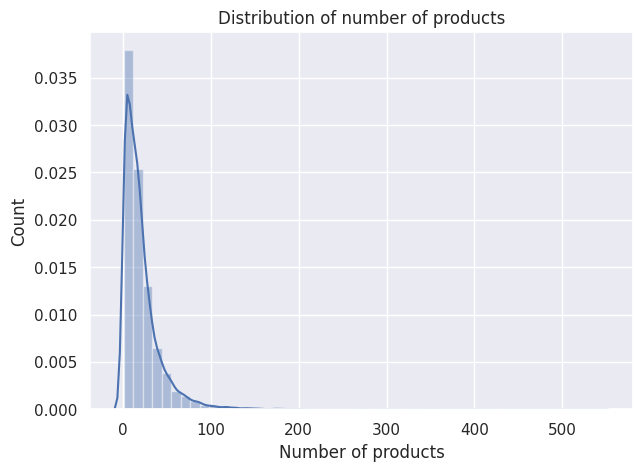

In [24]:
sns.distplot(df_UK_single_transaction["Number of Products"])
plt.gca().set(title="Distribution of number of products",
              xlabel="Number of products", ylabel="Count")
plt.show()

Number of products
PDF [7.72164825e-01 1.64704469e-01 4.12662182e-02 1.32148006e-02
 4.68524748e-03 1.74195099e-03 7.80874580e-04 4.20470927e-04
 6.00672753e-05 1.20134551e-04 1.20134551e-04 0.00000000e+00
 1.20134551e-04 1.80201826e-04 6.00672753e-05 6.00672753e-05
 1.20134551e-04 0.00000000e+00 0.00000000e+00 1.80201826e-04]
CDF [0.77216482 0.93686929 0.97813551 0.99135031 0.99603556 0.99777751
 0.99855839 0.99897886 0.99903892 0.99915906 0.99927919 0.99927919
 0.99939933 0.99957953 0.9996396  0.99969966 0.9998198  0.9998198
 0.9998198  1.        ]


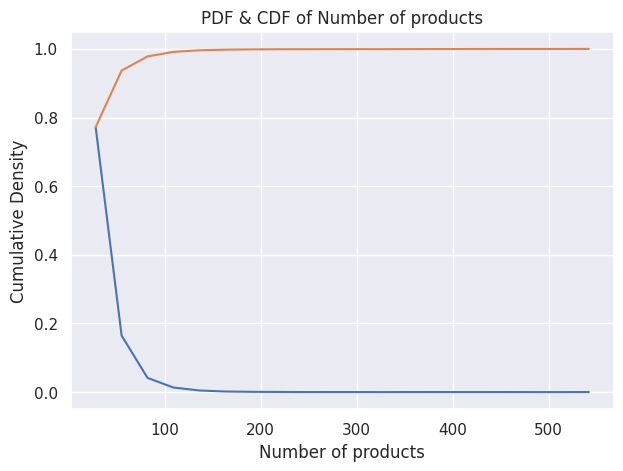

In [25]:
print("Number of products")
counts, bin_edges = np.histogram(
    df_UK_single_transaction["Number of Products"], bins=20, density=True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
print("PDF", pdf)
print("CDF", cdf)
plt.plot(bin_edges[1:], pdf)
plt.plot(bin_edges[1:], cdf)
plt.gca().set(title="PDF & CDF of Number of products",
              xlabel="Number of products", ylabel="Cumulative Density")
plt.show()

## As we can see here there 75% of transactions that has products ordered is approximately maximum 40 units

In [26]:
df_UK

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
387903,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,09/12/11 12:31,1.95,15804.0,United Kingdom
387904,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,09/12/11 12:49,2.95,13113.0,United Kingdom
387905,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,09/12/11 12:49,1.25,13113.0,United Kingdom
387906,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,09/12/11 12:49,8.95,13113.0,United Kingdom


    Here some values of the StockCode variable indicate a particular transaction (i.e. D for Discount ,M- Manual).

In [27]:
special_codes = df_UK[df_UK['StockCode'].str.contains(
    '^[a-zA-Z]+', regex=True)]['StockCode'].unique()

for code in special_codes:
    print("{:<15} -> {:<30}".format(code,
                                    df_UK[df_UK['StockCode'] == code]['Description'].unique()[0]))

M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
C2              -> CARRIAGE                      
POST            -> POSTAGE                       
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


     Above are the details of such transactions that has special code

## Now lets get some information about descriptions

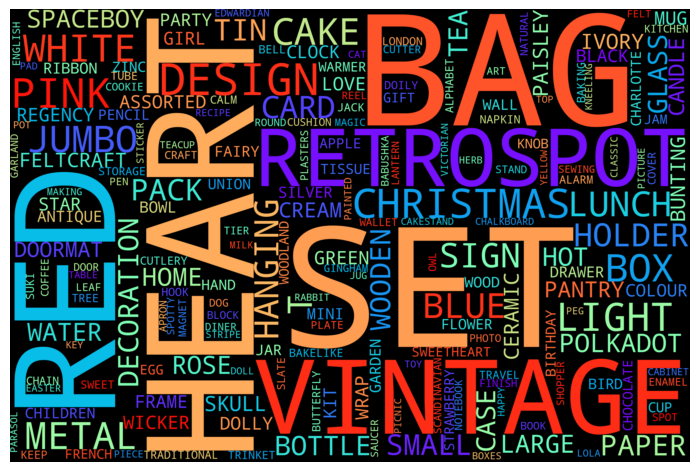

In [28]:
text = []

for t in df_UK["Description"]:
    text.append(t)
text = " ".join(text)

# wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='black',
                      colormap='rainbow', collocations=False, stopwords=STOPWORDS).generate(text)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## So we can see that most of the descriptions of products purchased have RED ,HEART,SET, RETROSPOT, VINTAGE, BAG JUMBO keywords in it

In [31]:
words = {}


def get_freqency(str):
    str = str.split()
    str2 = []

    for i in str:
        if i not in str2:
            str2.append(i)

    for i in range(0, len(str2)):
        words[str2[i]] = str.count(str2[i])
        print('Frequency of', str2[i], 'is :', str.count(str2[i]))


get_freqency(text)

df_words=pd.DataFrame(words.items(),columns=["Word","Count"])


Frequency of WHITE is : 14683
Frequency of HANGING is : 11783
Frequency of HEART is : 26621
Frequency of T-LIGHT is : 10401
Frequency of HOLDER is : 11632
Frequency of METAL is : 14585
Frequency of LANTERN is : 1755
Frequency of CREAM is : 5752
Frequency of CUPID is : 255
Frequency of HEARTS is : 3683
Frequency of COAT is : 1070
Frequency of HANGER is : 1457
Frequency of KNITTED is : 426
Frequency of UNION is : 3896
Frequency of FLAG is : 1139
Frequency of HOT is : 7158
Frequency of WATER is : 6809
Frequency of BOTTLE is : 7775
Frequency of RED is : 26386
Frequency of WOOLLY is : 300
Frequency of HOTTIE is : 300
Frequency of HEART. is : 300
Frequency of SET is : 33769
Frequency of 7 is : 426
Frequency of BABUSHKA is : 1966
Frequency of NESTING is : 296
Frequency of BOXES is : 1589
Frequency of GLASS is : 7883
Frequency of STAR is : 4222
Frequency of FROSTED is : 131
Frequency of HAND is : 3842
Frequency of WARMER is : 3350
Frequency of JACK is : 2745
Frequency of POLKA is : 123
Frequen

Frequency of FRIDGE is : 352
Frequency of US is : 64
Frequency of DINER is : 1968
Frequency of HOMEMADE is : 462
Frequency of SCENTED is : 978
Frequency of CANDLES is : 3218
Frequency of LES is : 56
Frequency of ENFANTS is : 56
Frequency of ROSE is : 5375
Frequency of CARAVAN is : 322
Frequency of 5 is : 1021
Frequency of MAGIC is : 1805
Frequency of 10 is : 1410
Frequency of REINDEER is : 465
Frequency of JAR is : 3283
Frequency of LID is : 1140
Frequency of KEEPSAKE is : 207
Frequency of DISCO is : 460
Frequency of BALL is : 1050
Frequency of POPCORN is : 1005
Frequency of SET/20 is : 775
Frequency of NAPKINS is : 2503
Frequency of CUPS is : 459
Frequency of RAIN is : 341
Frequency of HAT is : 75
Frequency of DELUXE is : 404
Frequency of ENGLISH is : 1925
Frequency of CUBE is : 174
Frequency of STRIPEY is : 406
Frequency of MICE is : 371
Frequency of SOLDIER is : 292
Frequency of SKITTLES is : 576
Frequency of SKIPPING is : 300
Frequency of ROPE is : 368
Frequency of DOMINOES is : 62

Frequency of TURQUOISE is : 333
Frequency of TREE is : 2809
Frequency of WREATH is : 1120
Frequency of ADVENT is : 306
Frequency of CALENDAR is : 632
Frequency of SACK is : 325
Frequency of CONE is : 82
Frequency of HEADS is : 602
Frequency of TAILS is : 602
Frequency of GAME is : 1105
Frequency of SNAP is : 683
Frequency of CARDS is : 2173
Frequency of TOWELS is : 974
Frequency of LONDON is : 3034
Frequency of PURPLE is : 835
Frequency of DRAWERKNOB is : 131
Frequency of APRON is : 1969
Frequency of SANTAS is : 121
Frequency of MUSHROOM is : 280
Frequency of CHALK is : 748
Frequency of STICKS is : 877
Frequency of HAIRBAND is : 344
Frequency of HAIRBANDS is : 103
Frequency of ANIMALS is : 794
Frequency of GO is : 114
Frequency of TO is : 371
Frequency of FAIR is : 127
Frequency of URBAN is : 61
Frequency of TOADSTOOLS is : 357
Frequency of LEAVES is : 301
Frequency of CUPCAKE is : 199
Frequency of LACE is : 1024
Frequency of CATCH is : 269
Frequency of COTTON is : 691
Frequency of BEA

Frequency of STRIPE is : 1271
Frequency of FRINGE is : 157
Frequency of HAMMOCK is : 197
Frequency of DEC is : 199
Frequency of CROSSBONES is : 219
Frequency of 45x30cm is : 37
Frequency of 40x40cm is : 171
Frequency of PONY is : 76
Frequency of CORDON is : 104
Frequency of BARRIER is : 104
Frequency of CAMOUFLAGE is : 160
Frequency of TEDDY is : 204
Frequency of AIR is : 46
Frequency of HOSTESS is : 46
Frequency of LETTER is : 565
Frequency of FOUR is : 417
Frequency of LOVEBIRDS is : 233
Frequency of No is : 87
Frequency of HUT is : 41
Frequency of KEY is : 1532
Frequency of BLOSSOM is : 335
Frequency of PASSPORT is : 299
Frequency of MOD is : 106
Frequency of CARDHOLDER is : 200
Frequency of BOOK is : 1522
Frequency of OVERNIGHT is : 69
Frequency of SPIRAL is : 68
Frequency of FEATHER is : 621
Frequency of PEN,COAL is : 100
Frequency of PEN,HOT is : 138
Frequency of AIRMAIL is : 128
Frequency of NUMBER is : 257
Frequency of 8 is : 200
Frequency of SMILEY is : 163
Frequency of CATS i

Frequency of AMETHYST is : 30
Frequency of PAIR is : 50
Frequency of HAIRCLIP is : 7
Frequency of GEMSTONE is : 26
Frequency of 45CM is : 14
Frequency of DROP is : 219
Frequency of EARRINGS is : 132
Frequency of HOOP is : 27
Frequency of EARRING is : 8
Frequency of LEAF is : 2369
Frequency of CLAM is : 32
Frequency of SHELL is : 101
Frequency of COCKLE is : 32
Frequency of FOB is : 918
Frequency of , is : 864
Frequency of GARAGE is : 215
Frequency of FRONT is : 159
Frequency of BACK is : 270
Frequency of CHOPSTICKS is : 173
Frequency of FROG is : 184
Frequency of PUPPET is : 62
Frequency of CANDLESTAND is : 5
Frequency of GAOLERS is : 196
Frequency of CHAMPAGNE is : 35
Frequency of BIG is : 241
Frequency of WRAP, is : 31
Frequency of SKY is : 32
Frequency of CURIO is : 248
Frequency of COLOURS is : 304
Frequency of FAN is : 579
Frequency of DUCK is : 55
Frequency of Bank is : 12
Frequency of Charges is : 12
Frequency of BUTTER is : 282
Frequency of KID is : 126
Frequency of ELEPHANT, i

Frequency of TRAVELOGUE is : 14
Frequency of "KEEP is : 10
Frequency of CLEAN" is : 10
Frequency of BULLET is : 10
Frequency of CAROUSEL is : 64
Frequency of TOXIC is : 133
Frequency of 0 is : 85
Frequency of PUPPIES is : 221
Frequency of SUNRISE is : 88
Frequency of PLASMATRONIC is : 10
Frequency of BURGUNDY is : 10
Frequency of RUSSIAN is : 3
Frequency of DUSTY is : 3
Frequency of 30CM is : 4
Frequency of SUNGLASSES is : 13
Frequency of BLACKCHRISTMAS is : 1
Frequency of FRAMES is : 51
Frequency of MIX is : 342
Frequency of SWEETIES is : 30
Frequency of WIRELESS is : 48
Frequency of DOORBELL is : 48
Frequency of LATTICE is : 142
Frequency of WILDFLOWER is : 55
Frequency of ENGINE/CAR is : 6
Frequency of LETS is : 34
Frequency of POLISHED is : 9
Frequency of NECKL is : 4
Frequency of BRONZE is : 3
Frequency of CRAWLIE is : 3
Frequency of LOLITA is : 22
Frequency of POURI is : 2
Frequency of CUSHIONS is : 6
Frequency of 65CMx65CM is : 5
Frequency of WINDMILL is : 298
Frequency of PALE 

Frequency of DARK is : 94
Frequency of DOLPHINS is : 27
Frequency of WHEELBARROW is : 62
Frequency of FRANGIPANI is : 5
Frequency of ROSEBUD is : 23
Frequency of CHENILLE is : 12
Frequency of SHAGGY is : 12
Frequency of TRIANGULAR is : 11
Frequency of RELAX is : 24
Frequency of NEST is : 95
Frequency of BOX/12 is : 39
Frequency of DAY is : 266
Frequency of PINK/FLOWER is : 4
Frequency of WASTE is : 11
Frequency of CARPET is : 24
Frequency of BAR is : 9
Frequency of CONDIMENT is : 8
Frequency of HILDA is : 11
Frequency of CONGRATULATIONS is : 3
Frequency of PUDDINGS is : 120
Frequency of ICON is : 113
Frequency of ELVIS is : 30
Frequency of DESK is : 7
Frequency of GORDON is : 12
Frequency of OVERCROWDED is : 12
Frequency of POOL. is : 12
Frequency of CITRUS is : 14
Frequency of BEETLES is : 30
Frequency of SITTING is : 90
Frequency of LIGHTHOUSE is : 3
Frequency of CRYSTAL+GLASS is : 9
Frequency of RESIN is : 6
Frequency of CHARLIE+LOLA"EXTREMELY is : 71
Frequency of BUSY" is : 71
Freq

Frequency of MONTAN is : 1
Frequency of GERDEN is : 5
Frequency of GARDENERS is : 1369
Frequency of KNEELING is : 1548
Frequency of HOUSEWORK is : 179
Frequency of "Y" is : 3
Frequency of NATIVITY is : 129
Frequency of GEBRA is : 15
Frequency of MISELTOE is : 5
Frequency of PEONY is : 21
Frequency of STILETTO is : 2
Frequency of FLOWR is : 3
Frequency of CAPIZ is : 1
Frequency of QUARTZ is : 1
Frequency of BRACLET is : 1
Frequency of Next is : 79
Frequency of Day is : 79
Frequency of Carriage is : 79
Frequency of BLANK is : 6
Frequency of LT is : 2
Frequency of LAUREL is : 206
Frequency of CHERUB is : 116
Frequency of OLLIE is : 253
Frequency of BEAK is : 253
Frequency of PINK/BLUE is : 12
Frequency of DISC/MIRROR is : 8
Frequency of ICICLE, is : 17
Frequency of SNOWFLAKES is : 43
Frequency of "E" is : 8
Frequency of KNICK is : 831
Frequency of KNACK is : 831
Frequency of HOLD is : 2
Frequency of BUBBLEGUM is : 197
Frequency of "L" is : 5
Frequency of "N" is : 5
Frequency of "H" is : 6

In [32]:
df_words

,Word,Count
0,WHITE,14683
1,HANGING,11783
2,HEART,26621
3,T-LIGHT,10401
4,HOLDER,11632
...,...,...
2233,"""W""",1
2234,"""Z""",1
2235,SIL'T,1
2236,SQU,1


## Lets get top 20 words having higher frequency

In [33]:
df_words.sort_values("Count",ascending=False)[:20]

,Word,Count
60,OF,34492
22,SET,33769
112,BAG,32962
2,HEART,26621
18,RED,26386
63,VINTAGE,22474
123,RETROSPOT,21737
262,DESIGN,20113
113,PINK,17257
81,CHRISTMAS,17122
